In [1]:
import numpy as np
import pandas as pd
import os

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchaudio
import torchaudio.transforms as T
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB, Resample
import soundfile as sf


In [2]:
csv_file = "../datasets/master_audio_dataset.csv"  # .. means go up a directory
df = pd.read_csv(csv_file)
df.head()

,file_path,filename,class,source_dataset
0,F:\1DAV_2.0\datasets\Ambulance\Emergency Vehic...,ambulance1.wav,siren,ambulance_sirens
1,F:\1DAV_2.0\datasets\Ambulance\Emergency Vehic...,ambulance10.wav,siren,ambulance_sirens
2,F:\1DAV_2.0\datasets\Ambulance\Emergency Vehic...,ambulance100.wav,siren,ambulance_sirens
3,F:\1DAV_2.0\datasets\Ambulance\Emergency Vehic...,ambulance101.wav,siren,ambulance_sirens
4,F:\1DAV_2.0\datasets\Ambulance\Emergency Vehic...,ambulance102.wav,siren,ambulance_sirens


In [ ]:
# OPTIONAL run - check duration distribution

def get_duration(file_path):
    try:
        duration = sf.info(file_path).duration
        return duration
    
    except:
        return None


# add new col in df
df['duration'] = df['file_path'].apply(get_duration)

print(df['duration'].describe())

print("\nDuration distribution:")
#print(df['duration'].value_counts(bins=35, sort=False))


bins = [0, 0.6, 1, 3, 4, 5, 10, float('inf')]
labels = ['0-0.6s', '0.6-1s', '1-3s', '3-4s', '4-5s', '5-10s', '>10s']

# Create binned column
df['duration_bin'] = pd.cut(df['duration'], bins=bins, labels=labels)

# See distribution
print(df['duration_bin'].value_counts().sort_index())

df.head()


count    14055.000000
mean         4.143614
std          2.252889
min          0.050000
25%          4.000000
50%          4.000000
75%          4.000000
max         28.544000
Name: duration, dtype: float64

Duration distribution:
duration_bin
0-0.6s     236
0.6-1s    1305
1-3s      1465
3-4s      7674
4-5s      2051
5-10s      811
>10s       513
Name: count, dtype: int64


,file_path,filename,class,source_dataset,duration,duration_bin
0,F:\1DAV_2.0\datasets\Ambulance\Emergency Vehic...,ambulance1.wav,siren,ambulance_sirens,3.000000,1-3s
1,F:\1DAV_2.0\datasets\Ambulance\Emergency Vehic...,ambulance10.wav,siren,ambulance_sirens,8.870023,5-10s
2,F:\1DAV_2.0\datasets\Ambulance\Emergency Vehic...,ambulance100.wav,siren,ambulance_sirens,11.157333,>10s
3,F:\1DAV_2.0\datasets\Ambulance\Emergency Vehic...,ambulance101.wav,siren,ambulance_sirens,9.728000,5-10s
4,F:\1DAV_2.0\datasets\Ambulance\Emergency Vehic...,ambulance102.wav,siren,ambulance_sirens,9.984000,5-10s


In [3]:
#  remove all clips over 5s and under 0.6s

short_clips = 0
long_clips = 0
unknowns = 0

print(f"df len: {len(df)}")
total = 0

to_drop = []  # indices to drop in df

for i, record in df.iterrows():
    try:
        info = sf.info(record['file_path'])
        duration = info.duration

        if duration < 0.6:
            to_drop.append(i)
            short_clips += 1

        elif duration > 5.0:
            to_drop.append(i)
            long_clips += 1

    except:
        df = df.drop(index=i)
        unknowns += 1
    
    total += 1


df = df.drop(index=to_drop)
df = df.reset_index(drop=True)

print(f"Total clips processed: {total}\n")

print(f"Long clips removed >5s: {long_clips}")
print(f"Short clips removed <0.6s: {short_clips}")
print(f"Unkown clips removed ???: {unknowns}")

df.head()


df len: 14055
Total clips processed: 14055

Long clips removed >5s: 1327
Short clips removed <0.6s: 232
Unkown clips removed ???: 0


,file_path,filename,class,source_dataset
0,F:\1DAV_2.0\datasets\Ambulance\Emergency Vehic...,ambulance1.wav,siren,ambulance_sirens
1,F:\1DAV_2.0\datasets\Ambulance\Emergency Vehic...,ambulance11.wav,siren,ambulance_sirens
2,F:\1DAV_2.0\datasets\Ambulance\Emergency Vehic...,ambulance116.wav,siren,ambulance_sirens
3,F:\1DAV_2.0\datasets\Ambulance\Emergency Vehic...,ambulance122.wav,siren,ambulance_sirens
4,F:\1DAV_2.0\datasets\Ambulance\Emergency Vehic...,ambulance149.wav,siren,ambulance_sirens


In [4]:
print(f"Total Samples: {len(df)}")

print(f"Classes: {df['class'].unique()}\n")

print(df['class'].value_counts(),"\n")

min_samples = min(df['class'].value_counts())
print(f"Min Samples: {min_samples}")

Total Samples: 12496
Classes: ['siren' 'other' 'horn']

class
other    9802
siren    1771
horn      923
Name: count, dtype: int64 

Min Samples: 923


In [5]:
# balance dataset classes

target_sizes = {'siren': min_samples, 'horn': min_samples, 'other': 2*min_samples}

balanced_df = (
    df.groupby('class', group_keys=False) # splits dataframe into groups uniquely -> name (value of class), group (smaller dataframe)
    .apply(lambda x: x.sample(target_sizes[x.name], random_state=42))
    .reset_index(drop=True)
)

print(f"Total Samples: {len(balanced_df)}")

print(f"Classes: {balanced_df['class'].unique()}\n")
print(balanced_df['class'].value_counts())

balanced_df.head()

Total Samples: 3692
Classes: ['horn' 'other' 'siren']

class
other    1846
horn      923
siren     923
Name: count, dtype: int64


C:\Users\parve\AppData\Local\Temp\ipykernel_28404\72140224.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(target_sizes[x.name], random_state=42))


,file_path,filename,class,source_dataset
0,F:\1DAV_2.0\datasets\HornBase - A Car Horns Da...,J_7_B_S.wav,horn,hornbase
1,F:\1DAV_2.0\datasets\UrbanSound8K\UrbanSound8K...,156091-1-0-0.wav,horn,urbansound8k
2,F:\1DAV_2.0\datasets\HornBase - A Car Horns Da...,C_1_A_S_.wav,horn,hornbase
3,F:\1DAV_2.0\datasets\UrbanSound8K\UrbanSound8K...,72259-1-9-7.wav,horn,urbansound8k
4,F:\1DAV_2.0\datasets\HornBase - A Car Horns Da...,J_5_S_S_.wav,horn,hornbase


In [6]:
# preprocess - pad to 5s, resample to fixed sample rate

import librosa

def preprocess_audio(file_path, target_sr=22050, target_duration=5.0):

    data, sr = sf.read(file_path, dtype='float32')

    # convert to mono
    if data.ndim > 1:
        data = data.mean(axis=1) # avg across channels

    # resample
    if sr != target_sr:
        data = librosa.resample(data, orig_sr=sr, target_sr=target_sr)
    
    # padding
    target_samples = int(target_sr * target_duration)
    curr_samples = len(data)

    if curr_samples < target_samples:
        padding = target_samples - curr_samples
        left = padding // 2
        right = padding - left
        data = np.pad(data, (left, right)) # if odd pad 1 extra on right

    elif curr_samples > target_samples:
        print(f"Error - encountered longer file???")

    # Convert to PyTorch tensor with shape (1, samples)
    # Why: Need tensor for PyTorch training, shape (1, samples) = (channels, time)
    waveform = torch.from_numpy(data).float().unsqueeze(0)

    return waveform


In [7]:
# verify preprocess works


TARGET_SR = 22050
TARGET_DURATION = 5.0
TARGET_SAMPLES = int(TARGET_DURATION * TARGET_SR)

print(f"Target: {TARGET_SAMPLES} samples = {TARGET_DURATION}s @ {TARGET_SR} Hz\n")

# Test on 3 random samples with different durations
test_samples = balanced_df.sample(2, random_state=42)

for idx, row in test_samples.iterrows():
    print(f"Testing: {row['file_path']}")
    print(f"Class: {row['class']}")
    
    # Load with your function
    waveform = preprocess_audio(row['file_path'], TARGET_SR, TARGET_DURATION)
    
    print(f"Output shape: {waveform.shape}")
    print(f"Expected: (1, {TARGET_SAMPLES})")
    print(f"✓ Match: {waveform.shape == (1, TARGET_SAMPLES)}\n")

Target: 110250 samples = 5.0s @ 22050 Hz

Testing: F:\1DAV_2.0\datasets\HornBase - A Car Horns Dataset\HornBase - A Car Horns Dataset\Dataset\Dataset\J_8_A_S_.wav
Class: horn
Output shape: torch.Size([1, 110250])
Expected: (1, 110250)
✓ Match: True

Testing: F:\1DAV_2.0\datasets\UrbanSound8K\UrbanSound8K\audio\fold10\159742-8-0-10.wav
Class: siren
Output shape: torch.Size([1, 110250])
Expected: (1, 110250)
✓ Match: True



In [ ]:
# listen and visualise samples

In [8]:

def visualise_spectrogram(path):
    
    data, sr = sf.read(path)
    waveform = torch.from_numpy(data).float()
    if waveform.ndim > 1: waveform = waveform.mean(dim=1)  # mono
    waveform = waveform.unsqueeze(0)  # (1, samples)

    mel_db = T.AmplitudeToDB()(T.MelSpectrogram(sr, n_fft=1024, hop_length=256, n_mels=64)(waveform))
    print("Tensor shape (C, n_mels, T):", mel_db.shape)

    plt.imshow(mel_db[0].numpy(), origin='lower', aspect='auto', cmap='inferno')
    plt.colorbar(label='dB')
    plt.show()

Sample 323:


Tensor shape (C, n_mels, T): torch.Size([1, 64, 173])


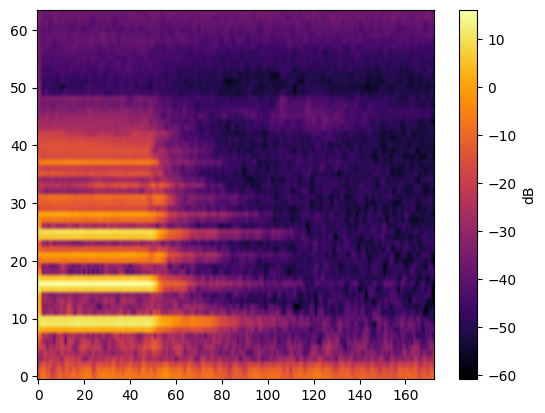

In [9]:
N = 1
samples = balanced_df[balanced_df['class']=='horn'].sample(N, random_state=42)

for i, sample in samples.iterrows():
    print(f"Sample {i}:")
    path = sample['file_path']

    display(Audio(path, rate=None)) # use file's sample rate
    visualise_spectrogram(path)

Sample 3092:


Tensor shape (C, n_mels, T): torch.Size([1, 64, 690])


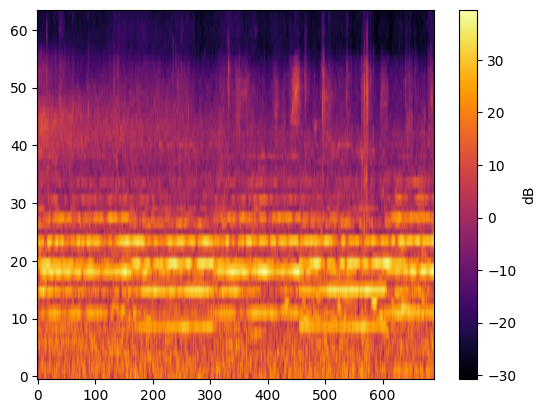

In [10]:
N = 1
samples = balanced_df[balanced_df['class']=='siren'].sample(N, random_state=42)

for i, sample in samples.iterrows():
    print(f"Sample {i}:")
    path = sample['file_path']

    display(Audio(path, rate=None)) # use file's sample rate
    visualise_spectrogram(path)

Sample 2496:


Tensor shape (C, n_mels, T): torch.Size([1, 64, 690])


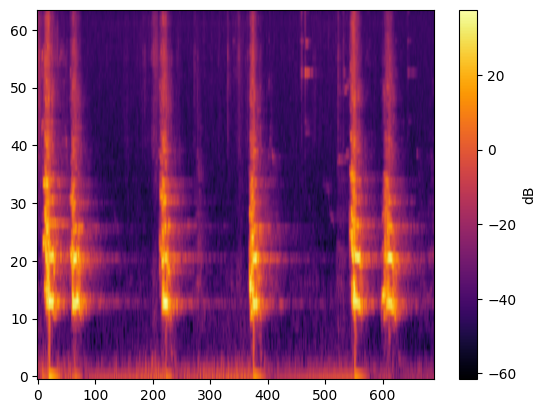

In [11]:
N = 1
samples = balanced_df[balanced_df['class']=='other'].sample(N, random_state=42)

for i, sample in samples.iterrows():
    print(f"Sample {i}:")
    path = sample['file_path']

    display(Audio(path, rate=None)) # use file's sample rate
    visualise_spectrogram(path)

In [12]:
# WAVEFORM AUGMENTATIONS

def time_shift(waveform, target_sr=22050):
    shift = int(torch.randint(-target_sr, target_sr, (1,)))
    waveform = torch.roll(waveform, shift, dims=1)
    return waveform


def add_noise(waveform):
    noise = torch.randn_like(waveform) * 0.005
    waveform += noise
    return waveform


def gain(waveform):
    gain = torch.FloatTensor(1).uniform_(0.7, 1.3)
    waveform = waveform * gain
    return waveform


def time_stretch(waveform):
    rate = torch.FloatTensor(1).uniform_(0.9, 1.1).item()
    waveform_np = waveform.squeeze(0).numpy()
    stretched = librosa.effects.time_stretch(waveform_np, rate=rate)
    target_len = waveform.shape[1]

    if len(stretched) < target_len:
        stretched = np.pad(stretched, (0, target_len - len(stretched)))
    else:
        stretched = stretched[:target_len]
    waveform = torch.from_numpy(stretched).unsqueeze(0)
    return waveform


def pitch_shift(waveform, target_sr=22050):
    n_steps = torch.FloatTensor(1).uniform_(-2, 2).item()  # ±2 semitones
    waveform_np = waveform.squeeze(0).numpy()
    shifted = librosa.effects.pitch_shift(waveform_np, sr=target_sr, n_steps=n_steps)
    waveform = torch.from_numpy(shifted).unsqueeze(0)
    return waveform



def apply_augmentations(waveform, target_sr=22050):

    waveform = waveform.clone()

    mask = np.random.uniform(0,1,size=5) # random probabilities - decide activation

    # time shift
    if mask[0] > 0.5:
        waveform = time_shift(waveform)
    
    # noise
    if mask[1] > 0.5:
        waveform = add_noise(waveform)

    # gain
    if mask[2] > 0.5:
        waveform = gain(waveform)
    
    # time stretch
    if mask[3] > 0.5:
        waveform = time_stretch(waveform)
    
    # pitch shift
    if mask[4] > 0.5:
        waveform = pitch_shift(waveform)
    
    return waveform


In [ ]:
# visualise wave augmentations



In [13]:
# SPECTROGRAM AUGMENTATIONS

def frequency_mask(spec, num_masks, mask_params):

    spec = spec.clone()
    num_mel_chanels = spec.shape[1]     # (1, n_mels, time)

    for _ in range(num_masks):
        f = torch.randint(0, mask_params, (1,)).item()
        f0 = torch.randint(0, num_mel_chanels - f, (1,)).item()
        spec[:, f0:f0+f, :] = 0
    
    return spec


def time_mask(spec, num_masks, mask_params):

    spec = spec.clone()
    num_time_steps = spec.shape[2]      # (1, n_mels, time)

    for _ in range(num_masks):
        t = torch.randint(0, mask_params, (1,)).item()
        t0 = torch.randint(0, num_time_steps - t, (1,)).item()
        spec[:, :, t0:t0+t] = 0

    return spec




In [14]:
class AudioDataset(Dataset):

    def __init__(self, dataframe, target_sr=22050, target_duration=5.0, n_mels=64,
                 n_fft=1024, hop_length=256, augment=False, n_augmentations=None):
        
        self.df = dataframe.reset_index(drop=True) # why reset?
        self.target_sr = target_sr
        self.target_duration = target_duration
        self.augment = augment
        self.n_augmentations = n_augmentations

        self.mel_transform = T.MelSpectrogram(
            sample_rate=target_sr,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels
        )

        self.db_transform = T.AmplitudeToDB()

        # CREATE LABEL ENCODING
        self.classes = sorted(self.df['class'].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)} # dict

        if self.augment:
            total_samples = len(self.df) * (1 + self.n_augmentations)
            print(f"Dataset created with {len(self.df)} original samples")
            print(f"With augmentation: {total_samples} total samples (1 original + {self.n_augmentations} augmented per sample)")
        else:
            print(f"Dataset created with {len(self.df)} samples (no augmentation)")
    
        print(f"Classes: {self.classes}")
        print(f"Class mapping: {self.class_to_idx}\n")
        
    
    def __len__(self):

        if self.augment:
            return len(self.df) * (1 + self.n_augmentations)
        else:
            return len(self.df)
    

    def __getitem__(self, idx):

        """
        Load and process a single sample.
        
        Returns:
            spectrogram: tensor of shape (1, n_mels, time_steps)
            label: integer class label
        """

        if self.augment:
            real_idx = idx // (1 + self.n_augmentations) # original sample which has file path
            aug_variant = idx % (1 + self.n_augmentations) # which version (0=original)
        else:
            real_idx = idx
            aug_variant = 0

        row = self.df.iloc[real_idx]
        file_path = row['file_path']
        label = self.class_to_idx[row['class']]

        waveform = preprocess_audio(file_path, self.target_sr, self.target_duration) 

        # WAVEFORM AUGMENTATIONS
        if self.augment and aug_variant > 0:
            waveform = apply_augmentations(waveform, self.target_sr)

        mel_spec = self.mel_transform(waveform) # how can we just put waveform ??
        mel_db = self.db_transform(mel_spec)

        # SPECTROGRAM AUGMENTATIONS
        if self.augment and aug_variant > 0:

            if np.random.uniform(0,1) > 0.5:
                mel_db = frequency_mask(mel_db, num_masks=2, mask_params=15)

            if np.random.uniform(0,1) > 0.5:
                mel_db = time_mask(mel_db, num_masks=2, mask_params=50)


        return mel_db, label




In [15]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(balanced_df, test_size=0.3, stratify=balanced_df['class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], random_state=42)

print(f"Train: {len(train_df)} samples")
print(f"Val: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")



Train: 2584 samples
Val: 554 samples
Test: 554 samples


In [16]:
train_dataset = AudioDataset(train_df, augment=False, n_augmentations=4)
val_dataset = AudioDataset(val_df, augment=False)
test_dataset = AudioDataset(test_df, augment=False)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)   # new - drop last batch as its likely to be smaller, can make grad noisy
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


Dataset created with 2584 samples (no augmentation)
Classes: ['horn', 'other', 'siren']
Class mapping: {'horn': 0, 'other': 1, 'siren': 2}

Dataset created with 554 samples (no augmentation)
Classes: ['horn', 'other', 'siren']
Class mapping: {'horn': 0, 'other': 1, 'siren': 2}

Dataset created with 554 samples (no augmentation)
Classes: ['horn', 'other', 'siren']
Class mapping: {'horn': 0, 'other': 1, 'siren': 2}



In [17]:
class AudioCNN(nn.Module):

    def __init__(self, num_classes=3, n_mels=64):
        super(AudioCNN, self).__init__()

        # input (batch, 1, n_mels, time)

        # Conv block 1
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2,2)
        self.dropout1 = nn.Dropout(0.25)

        # Conv block 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2,2)
        self.dropout2 = nn.Dropout(0.25)

        # Conv block 3
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2,1)
        self.dropout3 = nn.Dropout(0.25)

        # Conv block 4
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(1,2)
        self.dropout4 = nn.Dropout(0.25)

        # global avg pooling
        self.GAP = nn.AdaptiveAvgPool2d((1,1))

        # fully connected layers
        self.fc1 = nn.Linear(512, 256)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    
    def forward(self, x):
        # Conv Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Conv Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Conv Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Conv Block 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool4(x)
        x = self.dropout4(x)
        
        # Global Average Pooling
        x = self.GAP(x)
        x = x.view(x.size(0), -1)
        
        # Fully Connected
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        
        return x




In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = AudioCNN(num_classes=3, n_mels=64)
model = model.to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
                                                 



cuda


In [ ]:
# training loop

model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

epochs = 50
best_val_acc = 0.0

for epoch in range(epochs):

    model.train()
    total_train_loss = 0

    for x, y in train_loader:       # input, actual output

        x = x.to(device)
        y = y.to(device)

        # forward
        preds = model(x)
        loss = criterion(preds, y)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()


    model.eval()        # doesnt train
    total_val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in val_loader:

            x = x.to(device)
            y = y.to(device)

            # forward
            preds = model(x)
            loss = criterion(preds, y)

            # no backward - just eval

            #   % acc
            _,predicted = torch.max(preds, 1)
            correct += (y == predicted).sum().item()
            total += y.size(0)

            total_val_loss += loss.item()

    val_accuracy = correct * 100 / total
    
    mean_train_loss = total_train_loss / len(train_loader)   # / num batches
    mean_val_loss = total_val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{epochs}    Train Loss: {mean_train_loss:.4f}   Val Accuracy: {val_accuracy:.2f}%    Val Loss: {mean_val_loss:.4f}")


    # save best model
    if val_accuracy > best_val_acc:

        best_val_acc = val_accuracy
        torch.save(model.state_dict(), os.path.join(model_dir, "best_model.pth"))
        print(f"Saved new best model at epoch {epoch+1}\n")



Epoch 1/50    Train Loss: 0.4307   Val Accuracy: 80.51%    Val Loss: 0.5648
Saved new best model at epoch 1

Epoch 2/50    Train Loss: 0.3833   Val Accuracy: 83.39%    Val Loss: 0.4224
Saved new best model at epoch 2

Epoch 3/50    Train Loss: 0.3689   Val Accuracy: 79.96%    Val Loss: 0.4427
Epoch 4/50    Train Loss: 0.3565   Val Accuracy: 83.03%    Val Loss: 0.4175
Epoch 5/50    Train Loss: 0.3064   Val Accuracy: 77.44%    Val Loss: 0.5872
Epoch 6/50    Train Loss: 0.3034   Val Accuracy: 88.63%    Val Loss: 0.2936
Saved new best model at epoch 6



Test Accuracy: 88.45%
[[131   5   3]
 [ 10 226  41]
 [  3   2 133]]


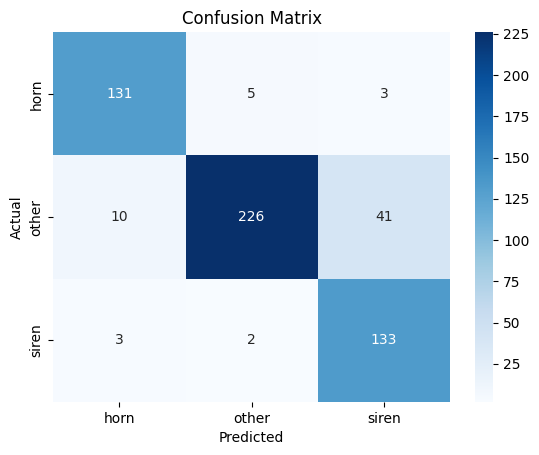


Classification Report:
               precision    recall  f1-score   support

        horn       0.91      0.94      0.93       139
       other       0.97      0.82      0.89       277
       siren       0.75      0.96      0.84       138

    accuracy                           0.88       554
   macro avg       0.88      0.91      0.89       554
weighted avg       0.90      0.88      0.89       554



In [ ]:
# test 

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

model_path = os.path.join(model_dir, "best_model.pth")

model = AudioCNN()
model = model.to(device)

model.load_state_dict(torch.load(model_path))
model.eval()

class_names = ["horn", "other", "siren"] # test_dataset.classes

correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:

        x = x.to(device)
        y = y.to(device)

        # forward
        preds = model(x)

        predictions = preds.argmax(dim=1)
        correct += (predictions == y).sum().item()
        total += y.size(0) 

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

test_acc = correct * 100 / total
print(f"Test Accuracy: {test_acc:.2f}%")


cm = confusion_matrix(all_labels, all_preds)

plt.figure(1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))


In [ ]:

#### 